# Exploration 08
---
## 뉴스 요약봇 만들기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


## 추상적 요약

### 데이터 준비하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
data.sample(10)

,headlines,text
97994,Ashes of modern frisbee inventor were moulded ...,"The inventor of the modern frisbee, Ed Headric..."
82652,GST hurdles will be removed in 2 months: Arvin...,"Speaking after the launch of GST, Chief Econom..."
51236,India's 1st Garbage Festival organised in Chha...,The Raipur Municipal Corporation in Chhattisga...
39281,Was portrayed as lesbian on reality show: Aash...,"Television actress Aashka Garodia, who was a p..."
73084,Infosys shares rise over 4% on Nandan Nilekani...,Shares of IT giant Infosys rose as much as 4.5...
14141,2-storey apartment becomes UK's costliest home...,A two-storey apartment in London's One Hyde Pa...
63398,50 pregnant women fall ill after antibiotic in...,Over 50 pregnant women and a few new mothers f...
76133,Disney honours two-year-old boy killed by alli...,A lighthouse memorial has been unveiled for a ...
56070,"Users are time poor, consumption rich: ZestMon...","Talking about high-end consumer demographic, B..."
91203,"If petrol can be stolen, why can't EVMs be hac...",Samajwadi Party leader and former Uttar Prades...


In [6]:
# text를 본문, headlines를 이미 요약된 데이터로 사용
data = data[['text','headlines']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,text,headlines
87624,CBSE's marks moderation policy was adopted in ...,What is the CBSE's marks moderation policy?
21134,"Speaking about his two-year-old son Ahil, Salm...","With the attention, Ahil thinks he's already a..."
71553,The Centre on Wednesday told the Supreme Court...,Have set up a panel on data protection: Centre...
77034,The Bombay High Court has reduced a woman's mo...,Mumbai woman lies about unemployment to claim ...
2570,Wishing ex-India captain Rahul Dravid on his 4...,Is deewar ka saaf mann aur hriday bhi hai: Seh...
78202,The Home Ministry has revealed that human righ...,J&K tops list on human rights violation under ...
55569,A group of 20 Hindu activists allegedly disrup...,Hindu activists disrupt Christmas celebrations...
14482,"Irish mixed martial artist Conor McGregor, the...",McGregor loses to Khabib on return to UFC afte...
33286,Gujarat Assembly Speaker Rajendra Trivedi on S...,Gujarat Assembly Speaker says BR Ambedkar was ...
7374,"Sachin Tendulkar, in his tweet for Gautam Gamb...",You had a Gambhir role in our win in WC finals...


### 데이터 전처리

In [7]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾸기
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


Null이 없으므로 `dropna()` 없이 그대로 사용

In [10]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어 리스트
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [25]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [14]:
clean_text = []
# 전체 text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [17]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


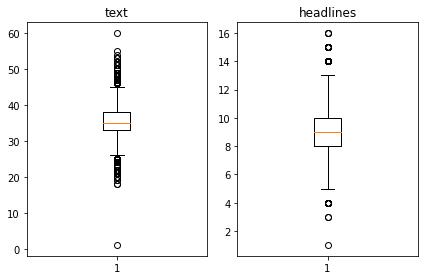

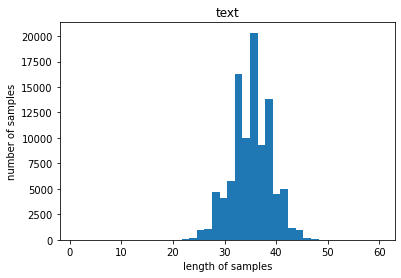

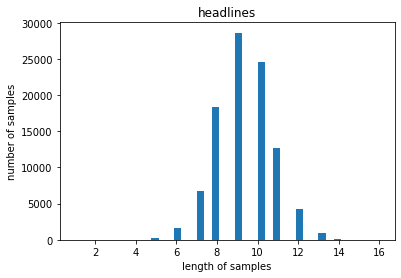

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
text_max_len = 50
headlines_max_len = 8
print('=3')

=3


In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 27105


In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
19,union minister dharmendra pradhan wednesday cl...,odisha cm patnaik controls mining mafia union ...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,indian space research organisation wednesday u...,isro unveils bengaluru centre for manned space...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,least people killed others injured saudi arabi...,killed injured in saudi arabia floods,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,investigators searching lost plane carrying ar...,seat cushions from missing plane carrying foot...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland chopper scam co accused rajiv s...,agustawestland scam accused rajiv saxena extra...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [24]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[18684 12801   409 ... 18116  8351 16305]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 5421


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42378
등장 빈도가 6번 이하인 희귀 단어의 수: 30655
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11723
단어 집합에서 희귀 단어의 비율: 72.3370616829487
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.274328023074515


In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5, 17, 34, 7790, 183, 35, 731, 996, 101, 1471, 3208, 5386, 1421, 5076, 4627, 3150, 5386, 584, 6768, 66, 1842, 1870, 7410, 1890, 6001, 5386, 1733, 44, 24, 75, 174, 4, 1118, 243, 5387], [114, 3381, 325, 1024, 3382, 239, 122, 626, 1249, 3209, 1, 31, 1708, 259, 1, 1144, 122, 501, 114, 155, 799, 5565, 114, 458, 33, 146, 538, 2450, 3209, 263, 1046, 791, 594, 606, 239, 122, 114], [149, 15, 2355, 62, 48, 1, 173, 544, 1312, 94, 911, 54, 6, 6483, 31, 1617, 90, 24, 75, 26, 1, 217, 2000, 9, 519, 1751, 1433, 770, 3719, 661]]


In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18893
등장 빈도가 5번 이하인 희귀 단어의 수: 14250
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4643
단어 집합에서 희귀 단어의 비율: 75.4247604933044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.165102183125033


In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 204, 306, 20, 45], [1, 60, 523], [1, 307, 696, 431, 4, 137, 798], [1, 330, 32, 3, 307, 3, 179, 22, 116], [1, 32, 3, 1551, 284, 365, 3, 169]]
target
decoder  [[204, 306, 20, 45, 2], [60, 523, 2], [307, 696, 431, 4, 137, 798, 2], [330, 32, 3, 307, 3, 179, 22, 116, 2], [32, 3, 1551, 284, 365, 3, 169, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 13
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 21671
훈련 레이블의 개수 : 21671
테스트 데이터의 개수 : 5420
테스트 레이블의 개수 : 5420


In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### 모델 설계하기

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [42]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=64, callbacks=[es], epochs=30)

Epoch 1/30
339/339 [==============================] - 234s 661ms/step - loss: 4.6489 - val_loss: 4.3034
Epoch 2/30
339/339 [==============================] - 222s 654ms/step - loss: 4.2552 - val_loss: 4.0602
Epoch 3/30
339/339 [==============================] - 221s 651ms/step - loss: 4.0229 - val_loss: 3.9002
Epoch 4/30
339/339 [==============================] - 221s 652ms/step - loss: 3.8267 - val_loss: 3.7401
Epoch 5/30
339/339 [==============================] - 221s 652ms/step - loss: 3.6528 - val_loss: 3.6251
Epoch 6/30
339/339 [==============================] - 220s 650ms/step - loss: 3.5094 - val_loss: 3.5370
Epoch 7/30
339/339 [==============================] - 220s 649ms/step - loss: 3.3938 - val_loss: 3.4821
Epoch 8/30
339/339 [==============================] - 220s 649ms/step - loss: 3.2873 - val_loss: 3.4332
Epoch 9/30
339/339 [==============================] - 220s 649ms/step - loss: 3.1889 - val_loss: 3.3859
Epoch 10/30
339/339 [==============================] - 220s 650m

_기존 코드에서 `batch_size`와 `epoch`만 조정하여 학습을 진행하였다._
<br><br>

`epoch`을 30으로 설정하였지만, `EarlyStopping` 을 이용하여 그전에 학습이 종료된 것을 볼 수 있다. 위 코드에서는 `val_loss`의 손실이 증가하는 현상이 2회 관측되면 학습이 멈추도록 설정되어 있다.

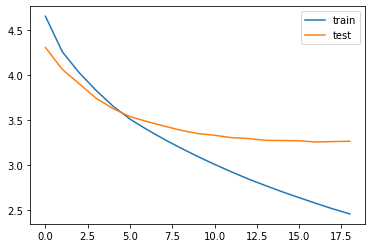

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

위 그래프를 살펴보면, train set 과 test set 간의 validation loss의 차이가 꽤 큰 것으로 보아 train set에 overfitting 된 것으로 보인다. 

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### 모델 테스트

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [142]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : gautam managing director sequoia capital india resigned working venture capital firm years involved least sequoia technology enabled portfolio firms like oyo rooms ola urban joining sequoia worked management consulting firm company 
실제 요약 : capital india director quits 
예측 요약 :  flipkart founder acquires


원문 : former union minister currently bjp spokesperson hussain sunday said pm narendra modi favourite prime ministerial candidate muslims next year lok sabha polls muslims like pm modi crore people country indians added parties seen vote bank hussain said 
실제 요약 : pm modi muslims pm candidate 
예측 요약 :  pm modi of gujarat cm


원문 : video shot kashmir university showed students sitting national anthem played video shot ceremony central university kashmir july shows people standing anthem students chose remain 
실제 요약 : college students during national anthem in 
예측 요약 :  crpf jawan arrested for


원문 : indian captain virat kohli became fastest player score runs international cricket 

## 추출적 요약 
_코드가 추상적 코드에 비하여 짧아 구분은 생략하였다._

In [112]:
import requests
from summa.summarizer import summarize

In [125]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [135]:
data['summarize'] = data['text'].apply(lambda x : summarize(x, ratio = 0.5))

기존의 노드에서는 txt 파일을 불러왔지만, 이번 프로젝트에서는 csv 파일을 이용하였기 때문에 추상적 요약과 마찬가지로 table에 추가하는 방법을 이용했다. <br><br>
또한 `ratio`의 값이 `0.5`인 것이 너무 크다고 생각했지만, 이보다 작게 했을 때(`0.1`, `0.3`, `0.4`)에는 요약이 되지 않는 경우가 많았다.

In [138]:
print(data.isnull().sum())

headlines    0
text         0
summarize    0
dtype: int64


Null 값이 존재하지 않으므로 `dropna` 함수를 사용하지 않았다.

In [140]:
data.sample(10)

,headlines,text,summarize
81055,Ferrofluids could be used as thrusters for sat...,US-based researchers have created a computatio...,Ferrofluids are liquids containing iron nanopa...
67836,Cricketer penalised for 'fake fielding' for 1s...,Australian domestic side Queensland's Marnus L...,"During a one-day match on Friday, Labuschagne ..."
90256,Assam declared disturbed area under AFSPA for ...,The government has declared Assam a 'disturbed...,Assam is under the AFSPA since November 1990.
84465,"Mamata calls for peace in Darjeeling, flies to...",West Bengal CM Mamata Banerjee has appealed to...,She said that her ministers were monitoring th...
5092,Will show Modi govt how to treat minorities: P...,Pakistan PM Imran Khan has said that he'll sho...,Pakistan PM Imran Khan has said that he'll sho...
78738,Assam people slam Centre as PM visits flood-hi...,After Prime Minister Narendra Modi visited flo...,After Prime Minister Narendra Modi visited flo...
8310,You cannot drop someone like Mithali Raj: Suni...,Reacting to Mithali Raj being dropped from the...,Reacting to Mithali Raj being dropped from the...
58696,Dogs lick mouths to communicate with angry hum...,Dogs lick their mouths to communicate with ang...,Dogs lick their mouths to communicate with ang...
92582,Constitutional reforms don't make me dictator:...,Turkish President Recep Tayyip ErdoÃÂan has ...,Turkish President Recep Tayyip ErdoÃÂan has ...
46170,40 transgenders apply for post of constable in...,Around 40 transgenders have reportedly applied...,Around 40 transgenders have reportedly applied...


In [147]:
for i in range(0, 10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", data['summarize'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

실제 요약 : PM Modi stops speech after cameraman faints, asks officers to help
예측 요약 : PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman.

# 회고

## 1. 모델에 대한 평가

이번 프로젝트는 텍스트 요약(Text Summarization) 원문의 긴 텍스트 파일에 대해서 핵심주제를 짧은 문장으로 변환하는 것을 의미한다. 이 때, 원문의 정보 손실이 최소화되어 내용을 함축할 수 있는 단어들로 구성되어야 하는 것이 중요하다.
<br>
텍스트 요약은 크게 추상적 요약(Abstract Summarization)과 추출적 요약(Extractive Summaraization)의 두가지 접근으로 나뉜다.
<br>

#### a) 추상적 요약

추상적 요약은 본 프로젝트의 첫번째 모델에서 사용된 방법으로, `seq2seq`를 이용하여 모델을 구현하였다. `epoch`에 대한 `val_loss` 그래프를 보면 학습횟수가 19일 때 `val_loss`가 가장 최소가 되지만, 한편으로는 train set 과 test set 사이의 validation loss 차이가 가장 큰 지점이기도 하다. 이러한 양상을 보이는 이유는 모델이 train set에 대하여 과적합 되었기 때문으로 보인다. `epoch`이 약 5회일 때 train set 과 test set 간의 validation loss 차이가 최소가 되지만 값 자체가 꽤 크기 때문에 보다 정확한 테스트를 위해서는 `epoch`을 5 ~ 19 사이의 값으로 하였으면 낫지 않을까 하고 생각한다. <br><br>


모델이 요약한 결과를 살펴보면

>1) <br> 
실제 요약 : virat kohli fastest to runs in international cricket <br>
예측 요약 :  virat kohli becomes fastest to international runs <br> <br>
2) <br> 
실제 요약 : service fined crore for smuggling <br> 예측 요약 :  fined million for billion

1)과 같이 실제 요약과 꽤 유사한 결과도 있었지만 2)처럼 아예 내용이 관련 없는 경우도 있었다. 이는 모델의 과적합, 그리고 새로운 단어를 생성하는데에 있어서는 보다 정교한 구성이 필요하기 때문이지 않을까 추측한다.

#### b) 추출적 요약

추출적 요약은 두번째 모델에서 사용된 방법으로`summ` 패키지의 `summarize` 함수를 이용하였다. `summarize` 함수의 `ratio`를 설정함에 있어, 너무 작은 값으로 하였을 때 요약이 아예되지 않는 것을 확인하고 0.1 단위로 끊어서 실행시킨 결과 0.5 이상의 값에서 모든 텍스트 데이터에 대한 요약을 성공적으로 확인할 수 있었다. 추출적 요약으로 출력된 결과를 살펴보면 아래와 같다.
>1) <br> 
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike<br>
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.
<br><br>
2) <br> 
실제 요약 : India get all out for 92, their lowest ODI total in New Zealand<Br>
예측 요약 : India's previous lowest ODI total in New Zealand was 108.
    
요약의 의미가 아주 비슷하진 않지만 추상적 요약에 비하여 핵심단어에 대해서는 더 잘 포함하고 있는 것으로 보인다. 이는 

## 후기

이번 프로젝트는 다른 자연어 관련 프로젝트에 비해 수월하게 진행했던 것 같다. 단, 의미가 제대로 되어있지 않는 요약문들에 대해 이것이 모델의 문제인지, 데이터셋의 문제인지에 대한 명료함이 필요한 것 같다. 또한 여태 진행했던 프로젝트들에 비하여 학습시간이 오래 걸렸는데 더 오래걸리는 프로젝트들이 훨씬 많이 있기에 익숙해질 필요가 있을 것 같다.